## Q-learning / Reinforcement learning, example 2, FrozenLake, custom grid

#### Imports + and make the environment

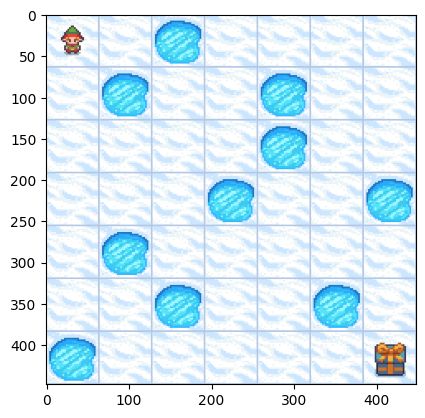

In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# define a custom map, S => start, G => goal, F => normal ice tile, H => hole 
custom_map = ["SFHFFFF",
              "FHFFHFF",
              "FFFFHFF",
              "FFFHFFH",
              "FHFFFFF",
              "FFHFFHF",
              "HFFFFFG"]


# create the FrozenLake environment, DISABLE SLIPPERY
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", desc=custom_map)

# it would be logical to have width + height
# we have to double-check that we get the correct values in this order 
grid_height, grid_width  = env.unwrapped.desc.shape

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

env.reset()
plt.imshow(env.render())

### This time, we'll use Q-learning and reinforcement learning for the agent (elf) to move in the world!

In [ ]:
# Grid experiments 
# I changed the gril small 4*4 also did the same experiment with different policies also with same policies 
# Another experiments I changed the gril with 7*7 but with few hurders and also with diferent policies. this also works fine.
# Third experiment I changed the goal location at different places, for example I placed the goal second last cell or last row and last colum (HFFFFGF).
# Last grid experiment is I changed grid and also set the goal at last, with maximum holes. 

In [ ]:
# custom_map = ["SFHFFFF",
#              "FHFFHFF",
#             "FFFFHFh",
#              "HFFFFFG"]

# I have sceen if there is small gridd then many changes happenend
# Agent took less steps to reach over the goal. next observation would also more refined and easy to go there within less time.
# There we need less traing time to train the agent. 

# Very Very important one

# I saw if the grid is small one then Silppery does work even Agent took more steps to reach over the goal
# But if the envoirment is slippery and grid is more complex and there are more holes, then
# Agent took very very long steps, sometime it stuck in loop and could not able to go for next step.
# with slippery and complex goal, its sometime reached to goal with very long or too many stepps, but 90 percents 
# Agent could not reach the goal, and stuck with loop etc


In [15]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

# in other words observation space => 4 x 4 grid => 16 cells
# action space => 4 different movements are possible => up, right, down, left

Observation space:
Discrete(49)

Action space:
Discrete(4)


In [16]:
# the above information is used to generate an EMPTY Q-table!
# basically Q-table will hold the Quality-values (Q-values) for each possible action
# for each possible cell in the grid (basically we map out all possibilities in this environment)
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(49, 4)

## Q-learning formula:

#### Q(s, a) = Q(s, a) + alpha * (r + y * max(Q(s', a')) - Q(s, a))

In [17]:
# let's code the above equation into Q-learning update -function
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

### Helper function to visualize the highest Q-values in the grid

In [18]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_height, grid_width)

In [19]:
# helper variables for our Q-learning training algorithm
# episode => how many times the AI tries to play the game as it learns

# learning rate (alpha) => usually good idea to start with 0.5, if the total rewards 
# of training are bouncing too much, try reducing slightly, for example, 0.35

# gamma => how much the AI values long-term rewards over short-term rewards
# gamma of 0.9 is very typical in basic Q-learning (a mix of short-term and long-rewards)

total_episodes = 10000

# how many steps our agent tries within one episode
# until we give up with that episode
max_steps = 50

learning_rate = 0.5
gamma = 0.9

# epsilon => not directly part of Q-learning update formula
# but used to determine how much our agent relies on current knowledge
# and how much the agent does wild guessing while training

# in ideal case => in the beginning of training => lots of guessing (high epsilon)
# but towards the end of training => less guessing and more trusting previous knowledge (smaller epsilon)
# in other words, we need guessing in the beginning so we can start learning at least something
# and towards the end there's no point guessing in the first steps of the environment, if we already
# know the optimal first steps in our current Q-table
epsilon = 0.9

# upper bound of our epsilon
max_epsilon = 0.9

# this is the lower bound, and our code is not going to decay the epsilon below this
min_epsilon = 0.01
decay_rate = 0.0005

### Train the agent with a for-loop (based on episodes)

#### NOTE! This grid is already much more complex, and a simple policy where we only use the +1 reward for goal is not going to cut, we need to fine-tune the policy

In [20]:
# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # => we get initial state + info-variable (info is not required usually)
    state, info = env.reset()

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    # WITHIN this episode of playing the game, play as long as our max steps define
    # (this example: give up after 50 steps -> probably not optimal route)
    for step in range(max_steps):
        # this is what we need to do:

        # PHASE 1: determine the next action!
        # use epsilon to decide whether we should trust previous knowledge
        # or take a wild guess
        # epsilon -> should we EXPLOIT our current knowledge or explore (wild guess)
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            action = np.argmax(Q_table[state, :])
        else:
            # let's explore => random action
            action = env.action_space.sample()


        # PHASE 2: get the results from the action done in PHASE 1
        # and unpack the results into: observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        # PHASE 3.1 -> punish the agent for making a move -> a very small adjustment
        # this will eventually guide the agent to choose the shortest path with least moves
        reward = reward - 0.01

        # PHASE 3.2 => if the agent drops into a hole => PUNISH HEAVILY
        # basically if game over is true and reward is 0 or less => game over with hole
        # if agent drops into a hole, we just adjust the reward accordingly, and stop this episode
        if done and reward <= 0:
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)
            total_rewards = total_rewards + reward
            break
            
        # PHASE 3.3: update the Q-table with the values we have right now
        # NOTE: this phase will be skipped if the agent dropped down a hole in previous section
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # PHASE 4: save current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # PHASE 5: check if we have either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            # # little bit of debugging of the current version of the Q-table
            # if total_rewards > 0 and step % 6 == 0:
            #     print(f"Current Q-table - Episode: {episode}")
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break

    # FINAL PHASE: AFTER THE EPISODE -> apply decay to epsilon
    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # only print the result if our rewards are positive
    if total_rewards >= 0:
        print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

Steps taken: 42
Episode 3512 done with total rewards: 0.5699999999999998, epsilon: 0.1637336351120693
Steps taken: 39
Episode 4039 done with total rewards: 0.5999999999999999, epsilon: 0.12812241036364946
Steps taken: 35
Episode 4061 done with total rewards: 0.6399999999999999, epsilon: 0.1268301841238896
Steps taken: 47
Episode 4078 done with total rewards: 0.5199999999999998, epsilon: 0.1258413361165496
Steps taken: 28
Episode 4079 done with total rewards: 0.71, epsilon: 0.12578342992624533
Steps taken: 43
Episode 4101 done with total rewards: 0.5599999999999998, epsilon: 0.12451679148042055
Steps taken: 33
Episode 4225 done with total rewards: 0.6599999999999999, epsilon: 0.11763237256267085
Steps taken: 38
Episode 4320 done with total rewards: 0.6099999999999999, epsilon: 0.11263935772387564
Steps taken: 22
Episode 4441 done with total rewards: 0.7699999999999999, epsilon: 0.10661378788153532
Steps taken: 44
Episode 4460 done with total rewards: 0.5499999999999998, epsilon: 0.10570

### Let's study the final optimal Q-table for our grid

In [21]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# each list in each row is one cell in the grid
# each value in a list is the quality of action based on:
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
# so in the first row best values are 1 and 2 => basically it doesn't matter
# if we go down or right from the first cell

# however, this is quite hard to visualize already, see the next version below

array([[-0.12745699, -0.2283509 , -0.41598723, -0.32740742],
       [-0.97980708, -0.98749999, -0.9830682 , -0.49190601],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.88318703, -0.80896628, -0.19980241, -0.62851872],
       [-0.2547114 , -0.41552691, -0.52966855, -0.15165316],
       [-0.15208941, -0.14968564, -0.11391033, -0.15791324],
       [-0.11546761, -0.12115371, -0.11296899, -0.11084807],
       [-0.15908102, -0.73678692, -0.70596107, -0.22893898],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.99007252, -0.95869639, -0.53998072, -0.99910426],
       [-0.44827736, -0.7128007 , -0.84132192, -0.9800795 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.258375  , -0.5       , -0.13110186, -0.57447508],
       [-0.12534791, -0.12002062, -0.12565368, -0.14823223],
       [-0.19281061, -0.28007145, -0.27616181, -0.22485301],
       [-0.50953404, -0.40648733, -0.47392076, -0.54154197],
       [-0.64195717, -0.

In [22]:
# ... we need a helper function for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)

df = pd.DataFrame(results)
df

# compare the summarized best values grid to the actual grid below

,0,1,2,3,4,5,6
0,-0.127457,-0.491906,0.000000,-0.199802,-0.151653,-0.113910,-0.110848
1,-0.159081,0.000000,-0.539981,-0.448277,0.000000,-0.131102,-0.120021
2,-0.192811,-0.406487,-0.625452,-0.867230,0.000000,-0.158775,-0.126429
3,-0.210554,-0.294287,-0.634361,0.000000,-0.360879,-0.370520,0.000000
4,-0.319457,0.000000,-0.965120,-0.066569,-0.068510,0.027083,0.457929
5,-0.709220,-0.566099,0.000000,0.036624,0.165002,0.000000,0.723977
6,0.000000,-0.369378,-0.206695,-0.027613,0.195509,0.471209,0.000000


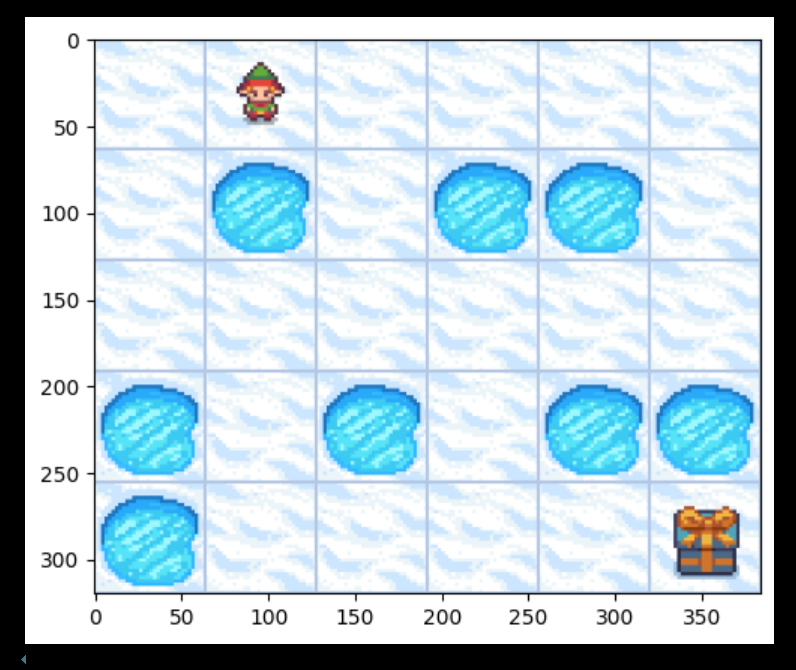

### Finally, let's allow our Q-learning -based AI to play the game with the optimized Q-table!

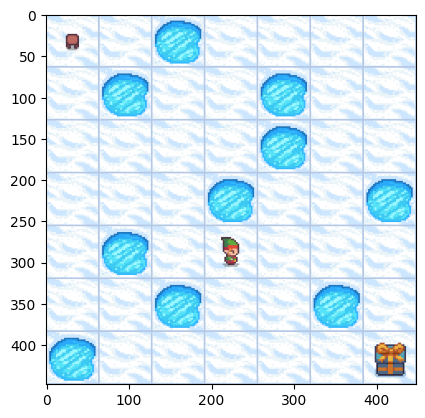

In [23]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(2):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state, :])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        time.sleep(0.3)

### Well done ELF (again)!